In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import pandas as pd
import pandahouse as ph
import scipy.stats as st

### Загрузка данных АБ-теста

In [6]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250520',
'user':'student',
'password':'dpo_python_2020'
}
# AB-тест проводился с 2025-05-02 по 2025-05-08
q = """
SELECT exp_group, 
       user_id,
       sum(action = 'like') as likes,
       sum(action = 'view') as views,
       likes/views as ctr
FROM   {db}.feed_actions 
WHERE toDate(time) between '2025-05-02' and '2025-05-08'
      and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

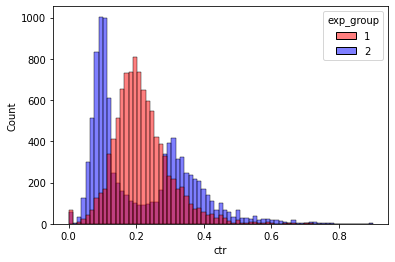

In [8]:
# Визуализация распределений в обоих групп на гистограмме
groups = sns.histplot(data=df, 
              x='ctr', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

### Сравнение тестов

In [9]:
control = df[df.exp_group == 1].ctr
test = df[df.exp_group == 2].ctr

#### T-тест

In [10]:
st.levene(control, test)

LeveneResult(statistic=2757.7940649593234, pvalue=0.0)

In [11]:
st.ttest_ind(control, test, equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Т-тест не видит различий в распределениях

#### тест Манна-Уитни

In [14]:
st.mannwhitneyu(control, test, alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Манна-Уитни может различить, что распределения не эквиваленты друг другу

#### T-тест на сглаженном ctr ($\alpha$ = 5)

In [16]:
# Функция для получения сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [17]:
# Расчет глобального CTR для обеих групп
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [18]:
# Отдельная переменная для групп
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

In [19]:
# Добавление колонки с сглаженным ctr
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [23]:
# T-тест для сглаженного ctr
st.ttest_ind(group1['smothed_ctr'], group2['smothed_ctr'])

Ttest_indResult(statistic=1.9532482382297538, pvalue=0.050804185424054626)

Т-тест на сглаженном ctr также не видит различии в средних

#### Пуасоновский бутстреп

In [24]:
# Определение функции для bootstrap
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    weights1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    weights2 = st.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (weights1*likes1).sum(
        axis=1)/(weights1*views1).sum(axis=1)
    
    globalCTR2 = (weights2*likes2).sum(
        axis=1)/(weights2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [27]:
# Сравнение двух групп при помощи, определенной сверху функуции bootstrap
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

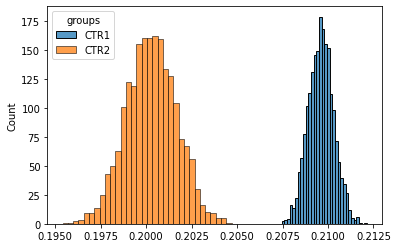

In [29]:
# Визуализация полученных результатов
sns.histplot(ctr1, label="CTR1")
sns.histplot(ctr2, label="CTR2")
plt.legend(title="groups")

<Axes: ylabel='Count'>

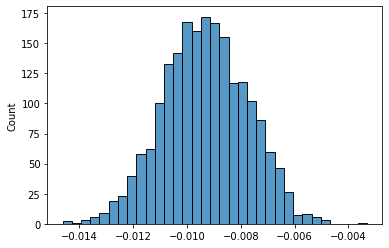

In [30]:
# Визуализация разницы между глобальными CTR
sns.histplot(ctr2 - ctr1)

CTR тестовой группы оказался строго меньше чем в контроле

#### Бакетное преобразование

In [31]:
# При помощи Clickhouse разбиваем группы на бакеты
q = """
SELECT exp_group, 
       bucket,
       sum(likes)/sum(views) as bucket_ctr
FROM (SELECT 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
   WHERE toDate(time) between '2025-05-02' and '2025-05-08'
         and exp_group in (2,1)
   GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

In [32]:
#тест Манна-Уитни
st.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

Тест Манна-Уитни видит различия в распределениях

In [33]:
#T-тест
st.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var=False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Также Т-тест видит различия в средних в бакетах

## Выводы

1. Проведены сравнения контрольной и тестовой групп при помощи таких тестов как:
   - Т-тест
   - Тест Манна-Уитни
   - T-тест на сглаженном ctr ($\alpha$ = 5)
   - Пуасоновский бутстреп
   - T-тест на бакетном преобразовании 
   - Тест Манна-Уитни на бакетном преобразовании
2. Результаты показали, что классический Т-тест и Т-тест на сглаженном ctr не видит различия в средних значениях в группах. Классический тест Манна-Уитни, а также тест Манна-Уитни на бакетном преобразовании строго видит, что распределения различаются. Пуасоновский бутстреп видит, что ctr в тестовой группе строго меньше чем в контрольной. Т-тест на бакетном преобразовании находит различия в средних.
3. Потенциальная причина, почему классический Т-тест и Т-тест на сглаженном ctr не видит различий с средних, это бимодальность распределения тестовой группы. Т-тест сравнивает средние значения и среднее значение может быть нерепрезентативным для описания данных, так как оно может находиться между пиками и не отражать реальную структуру распределения. Напротив, в тесте Манна-Уитни проверяется не средние или медианы, а эквивалентность распределения, что легко распознается этим тестом, что это не так. Пуасоновский бутстрап сравнивает не поюзерный ctr, а глобальный, поэтому он является довольно чувствительным, но медленным. Аналогичная причина для бакетного преобразования, который моделирует бутсреп в миниатюре. Сравнивает не поюзерный ctr, а потенциальный глобальных ctr и сравнивает его распределения в обоих группах.
4. Тестая группа явно раздилилась на два лагеря, одним изменения в алгоритме явно пошло на пользу в поисках постов, которые им понравятся, другим напротив алгоритм резко усугубил ситуацию. Это может быть потенциальная ошибка в алгоритме, где часто рекомендуется таже или перепост такой же публикации. 
5. **В любом случае не рекомендуется** выкатывать новый алгоритм на всех пользователей. Даже если бы все проведенные тесты не заметили бы различий в ctr, или все тесты показывали, что ctr выше в тестовой группе, вывод бы оставался таким же, так как в тестовой группе явно присутвуют большое кол-во недовольных или неудовлетвореных пользователей новым алгоритмом. Но также можно сослаться на то что более чувствительный пуассоновский бутстреп или бакетное преобразование, которые видят что ctr в тестовой группе строго меньше чем в контроле. 
